In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick
from dftpy.ions import Ions
from dftpy.formats import io
from dftpy.constants import Units
from dftpy.td.utils import calc_spectra_mu

In [3]:
ions = io.read('../../DATA/Mg8.vasp', format='vasp', names=['Mg'])

In [4]:
PP_list = ['../../DATA/Mg_OEPP_PZ.UPF']
grid = DirectGrid(ions.cell, spacing = 1.1)

In [5]:
ke = Functional(type='KEDF',name='TFvW')
xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list)
totalfunctional = TotalFunctional(KineticEnergyFunctional=ke,
                                XCFunctional=xc,
                                HARTREE=hartree,
                                PSEUDO=pseudo
                                 )

setting key: Mg -> ../../DATA/Mg_OEPP_PZ.UPF


In [6]:
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

In [7]:
optimization_options = {'econv' : 1e-9,'maxiter' : 100}

opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')

In [8]:
 rho0 = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.951916882520E+00      8.951917E+00    2.343046E+00    1       1       1.667714E-02    
!WARN: Change to steepest decent
1       -4.969090300003E+00     -1.392101E+01   1.122103E+00    1       4       3.942609E-02    
2       -5.991150574647E+00     -1.022060E+00   1.518278E-01    4       2       6.315422E-02    
3       -6.136119736368E+00     -1.449692E-01   1.739025E-02    9       1       1.001761E-01    
4       -6.144712254141E+00     -8.592518E-03   1.159542E-03    5       1       1.240530E-01    
5       -6.146210666402E+00     -1.498412E-03   1.868775E-04    9       2       1.662090E-01    
6       -6.146462116861E+00     -2.514505E-04   3.070997E-05    10      2       2.119610E-01    
7       -6.146493981715E+00     -3.186485E-05   5.229760E-06    8       2       2.502921E-01    
8       -6.146501135048E+00     -7.153333E-06   8.491837E-07    10      2       2.955499E-01  

In [9]:
 ke.options.update({'y':0})

In [10]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively
k = 1.0e-3 # kick_strength in a.u.
interval = 0.04

In [11]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        print("\r", end="")
        print(f"Progress: [{self.nsteps}/{self.max_steps}]", "|" * (self.nsteps*50 // self.max_steps), end="", flush=True)

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [12]:
# max_steps = 500
max_steps = 2000
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

Progress: [1999/2000] |||||||||||||||||||||||||||||||||||||||||||||||||

False

Text(0, 0.5, 'Dipole Moment (au)')

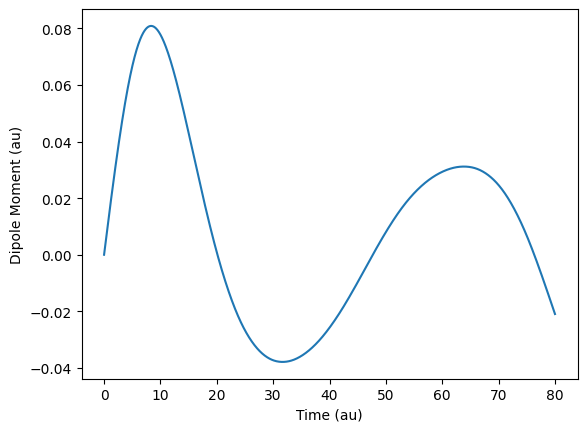

In [13]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
mu = np.asarray(runner.dipole)
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

(2.0, 11.0)

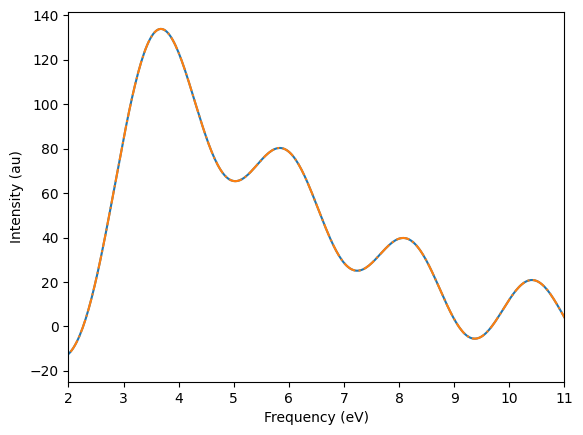

In [14]:
omega, spectra = calc_spectra_mu(delta_mu, interval, kick=k, use_fft=True)
omega1, spectra1 = calc_spectra_mu(delta_mu, interval, kick=k, use_fft=False)
plt.plot(omega*Units.Ha, spectra, '-')
plt.plot(omega1*Units.Ha, spectra1, '-.')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(2, 11)